In [2]:
#@title 1. Installs for collab
# !apt install python3-mpi4py cython3 libxc-dev gpaw-data
# !pip -q install gpaw

In [ ]:
#@title 2. Imports
import os
import sys

#Required installs: Numpy, ASE, GPAW paralelized, flatgraphene, SciPy
import numpy as np

import ase
from ase import Atoms
from ase.parallel import parprint
from ase.dft.kpoints import bandpath
from ase.dft.kpoints import get_special_points
from ase.dft.band_structure import get_band_structure, BandStructure
from ase.visualize import view

from gpaw import GPAW, FermiDirac, PW
from gpaw.lcao.tools import get_lcao_hamiltonian

import ase.units as units
from gpaw.utilities.tools import tri2full
import scipy.linalg as sla

import matplotlib.pyplot as plt

from gpaw import GPAW, PW, FermiDirac

/Users/xavierduane-tessier/anaconda3/envs/MD/lib/python3.13/site-packages/ase/dft/band_structure.py:14: VisibleDeprecationWarning: ase.dft.band_structure has been moved to ase.spectrum.band_structure. Please update your scripts; this alias will be removed in a future version of ASE.
  warnings.warn("ase.dft.band_structure has been moved to "


# **3b Silver**

In [8]:
# Silver primitive cell
a = 4.085
supercell = np.zeros((3,3)) # NUM VEC, DIM

# Cell vectors
supercell[0] = (a/2)*np.array([1,1,0])
supercell[1] = (a/2)*np.array([1,0,1])
supercell[2] = (a/2)*np.array([0,1,1])

positions = np.zeros((1,3)) # Num Particle, Dim

positions[0] = 0*supercell[0] + 0*supercell[1] + 0*supercell[2] # Set positions of particles in the cell (basis)

silver = ase.Atoms('Ag', positions, cell=supercell, pbc=True)

#Visualize
ase.visualize.view(silver)
view(silver, viewer='x3d')

In [5]:
# Manual parallel and more approximated band structure (good for bigger cells), manual cell and kpoints
band_parallelization = 1
nKpoints = 16
nBands = 10
basisN = 12 # 4 for carbon or Si sz(dzp), 9 for carbon or Si szp(dzp), 12 for Ag sz(dzp)
datapath = "/Users/xavierduane-tessier/Downloads/Untitled/MDpractice/Xavier's Folder/Research/P1_Lattices/data/"
Natoms = len(positions[:,0])

calc = GPAW(mode='lcao',
            basis='sz(dzp)',
            xc='PBE',
            kpts=(2, 2, 1),
            occupations=FermiDirac(0.01),
            txt=datapath+'graphene_bilayer_sc_.txt',
            parallel=dict(band=band_parallelization,              # band parallelization
                            augment_grids=True,  # use all cores for XC/Poisson
                            sl_auto=True)        # enable parallel ScaLAPACK
            )

silver.calc = calc
en1 = silver.get_potential_energy()
calc.write(datapath+'graphene_bilayer_sc_.gpw')


# Compute band path with a sequential approach, one kpt at a time, to use less memory.
points = ["W","L","G","X","W","K"]
path = bandpath(points, supercell, nKpoints) #They are in basis of recip vec, should multiply by recips
kpts = path.kpts

# *4 is valence per atom, for sz basis carbon has 4
eps_kn = []
lcaoH = np.zeros((nKpoints,Natoms*basisN,Natoms*basisN), dtype="cdouble")
lcaoS = np.zeros((nKpoints,Natoms*basisN,Natoms*basisN), dtype="cdouble")


#parprint('Calculation on', len(kpts), 'k points:')
ref, energies = [], []
for i, k in enumerate(kpts):
    # Restart from ground state and fix potential:
    calc = GPAW(datapath+'graphene_bilayer_sc_.gpw',
                fixdensity=True,
                kpts=[k],
                symmetry='off',
                txt=datapath+'graphene_bilayer_bs_.txt',
                parallel={'kpt':                 None,
                            'domain':              None,
                            'band':                1,
                            'order':               'kdb',
                            'stridebands':         False,
                            'augment_grids':       False,
                            'sl_auto':             False,
                            'sl_default':          None,
                            'sl_diagonalize':      None,
                            'sl_inverse_cholesky': None,
                            'sl_lcao':             None,
                            'sl_lrtddft':          None,
                            'use_elpa':            False,
                            'elpasolver':          '2stage',
                            'buffer_size':         None}        # enable parallel ScaLAPACK
                )

    silver.calc = calc

    en2 = calc.get_potential_energy()

    #Manual electronic structure
    h = calc.hamiltonian
    wfs = calc.wfs
    kpt_u = wfs.kpt_u

    for kpt in kpt_u:
        H_MM = wfs.eigensolver.calculate_hamiltonian_matrix(h, wfs, kpt)
        S_MM = wfs.S_qMM[kpt.q]
        tri2full(H_MM)

    H_MM = np.array(H_MM)
    S_MM = np.array(S_MM)

    lcaoH[i,:,:] = H_MM
    lcaoS[i,:,:] = S_MM


#Getting bands
eps_kn = []
for i in range(0,nKpoints):
    eps_n, c_Mn = sla.eigh(lcaoH[i,:,:], lcaoS[i,:,:])
    c_nM = c_Mn[:, eps_n.argsort()].transpose()

    eps_n.sort()
    eps_kn.append(eps_n)

eps_kn = np.array(eps_kn)*ase.units.Hartree #Necessary if not using parallel dump H



#Plotting parameters
lowestBand = int(Natoms*2 - nBands/2)
hightestBand = int(Natoms*2 + nBands/2) ##Bands is Natoms*valence, to get half we do valence/2, C has valence 4

E = np.zeros((nBands,nKpoints))
index = np.zeros(nKpoints)
for i in range(0,nKpoints):
    index[i] = i
    print(index[i])

j=0
for i in range(lowestBand,hightestBand):
    E[j] = eps_kn[:,i]
    j=j+1

with open("E_band.npy", 'wb') as f:
    np.save(f, E)

#Export
Positions = silver.get_positions()

with open("PosCalc.npy", 'wb') as f:
    np.save(f, Positions)

/Users/xavierduane-tessier/anaconda3/envs/MD/lib/python3.13/site-packages/gpaw/calculator.py:734: DeprecatedParameterWarning: The fixdensity keyword has been deprecated. Please use the GPAW.fixed_density() method instead.
  warnings.warn(


0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0


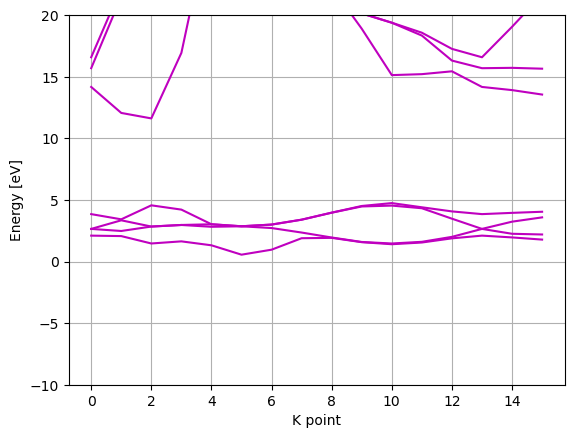

In [6]:
# Plot from saved file
E = np.load("E_band.npy")

ax = plt.gca()
ax.set_xlabel("K point")
ax.set_ylabel("Energy [eV]")
ax.set_ylim(-10, 20)
plt.grid()

for j in range(0,len(E)):
    plt.plot(index, E[j], '-m')

plt.show()